In [1]:
import re
from typing import List

import numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchdata
import torchtext
import spacy
from torchtext import data
from torchtext.datasets import PennTreebank

from matplotlib import pyplot as plt
from collections import defaultdict

from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
train_data, valid_data, test_data = PennTreebank()

In [3]:
train_data = [data for data in train_data]
valid_data = [data for data in valid_data]
test_data = [data for data in test_data]

In [4]:
print(train_data[:3])

['aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter', 'pierre <unk> N years old will join the board as a nonexecutive director nov. N', 'mr. <unk> is chairman of <unk> n.v. the dutch publishing group']


In [5]:
len(train_data)

42068

In [6]:
def sen_to_word(sen_list):
    line = []
    for sen in sen_list:
        for item in sen.split():
            line.append(item)
        line.append('<eos>')
    return line     

In [7]:
all_words = sen_to_word(train_data)
print(all_words[:100])

['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', '<eos>', 'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', '<eos>', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group', '<eos>', 'rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '<eos>', 'a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of']


In [8]:
#The number of processing units (neurons) in the hidden layers
hidden_size_l1 = 512
hidden_size_l2 = 512
hidden_size_l3 = 512
#The size for each batch of data
batch_size = 30
#The size of our vocabulary
vocab_size = 10000
embeding_vector_size = 150
#Sequence length
seq_len = 20

In [9]:
word_to_ix = {}
for word in all_words:
    if word not in word_to_ix:  # word has not been assigned an index yet
        word_to_ix[word] = len(word_to_ix)

In [10]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        #self.batch_size = batch_size
        self.hidden_size_l1 = hidden_size_l1
        self.hidden_size_l2 = hidden_size_l2
        self.vocab_size = vocab_size
        self.embeding_vector_size = embeding_vector_size
        
        self.word_embeddings = nn.Embedding(vocab_size, embeding_vector_size)
        
        self.lstm1 = nn.LSTM(embeding_vector_size, hidden_size_l1, dropout=0.5)
        self.lstm2 = nn.LSTM(hidden_size_l1, hidden_size_l2, dropout=0.5) 
        self.lstm3 = nn.LSTM(hidden_size_l2, hidden_size_l3, dropout=0.5)
        
        self.lin = nn.Linear(hidden_size_l3, vocab_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm1_out, _ = self.lstm1(embeds) #увеличить модель (три слоя) + dropout-ы (до 0.5) включить стандартные + L2-рег weight decay 1e-6
        lstm2_out, _ = self.lstm2(lstm1_out) #512 юнитов использовать; gradient clipping
        lstm3_out, _ = self.lstm3(lstm2_out)
        output = self.lin(lstm3_out) #бонус усреднение model avg
        return output

In [12]:
model = MyModel().cuda()

/mnt/hdd/student/anaconda/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
loss_function = nn.CrossEntropyLoss()

In [14]:
prep_inputs = prepare_sequence(all_words, word_to_ix)
prep_inputs = prep_inputs.tolist()

In [15]:
def preprocessing_data(batch_start):

    x = torch.tensor([prep_inputs[batch_start:batch_start+batch_size*seq_len]])
    
    return x.reshape(batch_size, seq_len).T

In [16]:
batch_num = (len(all_words) // (batch_size * seq_len))

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
#optimizer = optim.SGD(model.parameters(), lr=1, weight_decay=1e-6)

In [18]:
history = defaultdict(list)

In [19]:
all_words_valid = sen_to_word(valid_data)

valid_inputs0 = prepare_sequence(all_words_valid, word_to_ix)

valid_inputs0 = valid_inputs0.tolist()

valid_inputs = torch.tensor(valid_inputs0[:-1]).cuda()

valid_targets = torch.tensor(valid_inputs0[1:]).cuda()

In [20]:
t = 0
t1 = 0
logs = []
n = 5
L = batch_num
counter = 0

In [21]:
for epoch in range(30):
    
    loss_sum = 0
    pp_sum = 0
    k = 0
    
    print(epoch)
    
    for batch in range(batch_num):

        model.zero_grad()
        
        batch_start = batch * batch_size * seq_len
        
        
        inputs = preprocessing_data(batch_start).cuda()
        #print(inputs)
        targets = preprocessing_data(batch_start+1).cuda()
        #print(targets)
        targets = targets.reshape(batch_size*seq_len)
        #print(targets.size())
        
        outputs = model(inputs)
        outputs = outputs.reshape(batch_size*seq_len, vocab_size)
        #print(outputs.size()) 
        
        loss = loss_function(outputs, targets)
        
        
        loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), clip_value=3.5) #gradient clipping
        
        optimizer.step()
        
        perplexity  = torch.exp(loss)
        
        loss_sum += loss.item() 
        pp_sum += perplexity.item()
        k += 1
        counter += 1
    
    
    if k % L == 0 and t1 == 0:
        with torch.no_grad():
            valid_outputs = model(valid_inputs)
        loss_valid = loss_function(valid_outputs, valid_targets)
        perplexity_val  = torch.exp(loss_valid)
        v = perplexity_val.item()
        if t > n and v > min(logs):
            print("----- new optimizer -----")
            #optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
            optimizer = optim.ASGD(model.parameters(), lr=0.001, t0=0, lambd=0., weight_decay=1e-6)
            t1 = k
        logs.append(v)
        t = t + 1
     
        
    loss_mean = loss_sum / k
    pp_mean = pp_sum / k
    
    history['loss'].append(loss_mean)
    history['perplexity'].append(pp_mean)
    print('Loss:', loss_mean, 'PP:', pp_mean)

0
Loss: 6.321605800581871 PP: 651.3832311365511
1
Loss: 5.441333086279764 PP: 248.98420976499654
2
Loss: 5.062573664106808 PP: 171.94600482568808
3
Loss: 4.796964906738064 PP: 132.9695154658589
4
Loss: 4.569598662845545 PP: 106.53530949819773
5
Loss: 4.3597748587407015 PP: 86.64494335397434
6
----- new optimizer -----
Loss: 4.163339901232119 PP: 71.21229475463414
7
Loss: 4.20794603976994 PP: 76.6384364314969
8
Loss: 4.196078950085895 PP: 75.68197621985202
9
Loss: 4.188317770800951 PP: 75.07114796364515
10
Loss: 4.182165904611522 PP: 74.5941407146417
11
Loss: 4.176881047431079 PP: 74.18861171228028
12
Loss: 4.1721669278505 PP: 73.82975347539238
13
Loss: 4.167873984155846 PP: 73.50506202739004
14
Loss: 4.16391107699731 PP: 73.20694840931753
15
Loss: 4.1602174261833795 PP: 72.93036477730458
16
Loss: 4.156749463296845 PP: 72.67173174229494
17
Loss: 4.153475474626346 PP: 72.42844365195661
18
Loss: 4.1503715376610755 PP: 72.19853162272966
19
Loss: 4.147418902950029 PP: 71.98045119275733
20
L

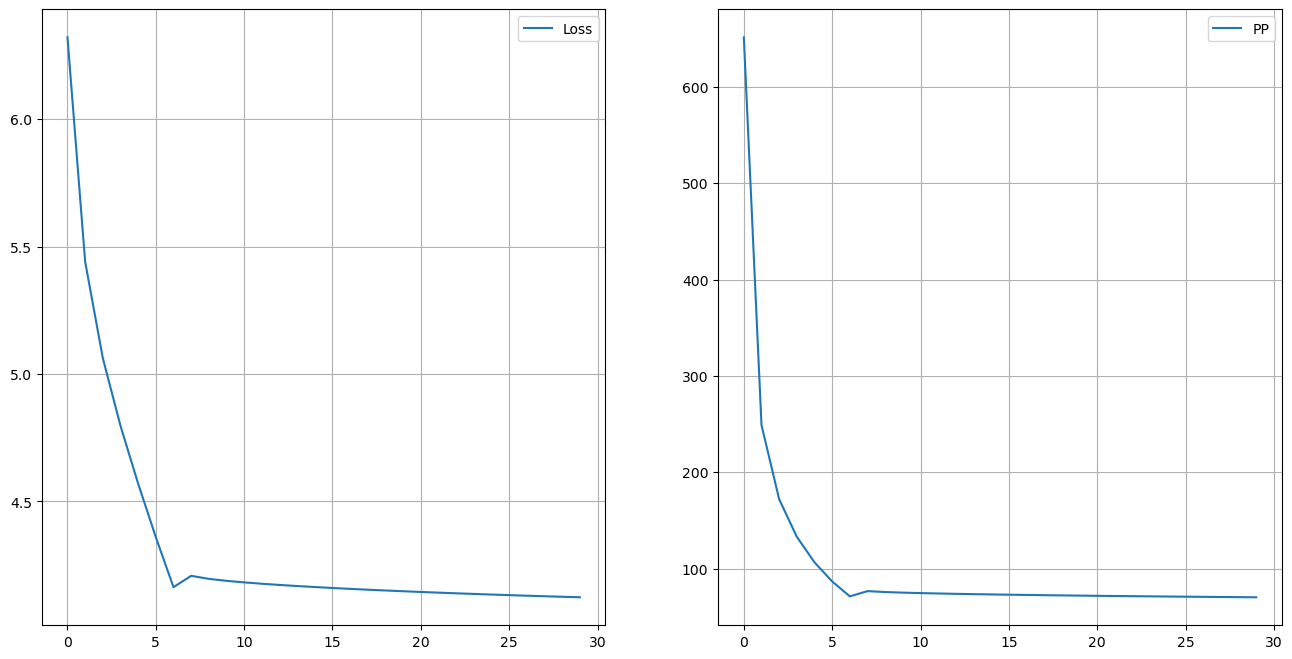

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].plot(history['loss'], label='Loss')
axes[1].plot(history['perplexity'], label='PP')
axes[0].legend()
axes[0].grid()
axes[1].legend()
axes[1].grid()
plt.show()

In [23]:
logs

[290.629150390625,
 192.93170166015625,
 163.31475830078125,
 152.92196655273438,
 149.53268432617188,
 151.53973388671875,
 160.47373962402344]

In [24]:
model.eval()

MyModel(
  (word_embeddings): Embedding(10000, 150)
  (lstm1): LSTM(150, 512, dropout=0.5)
  (lstm2): LSTM(512, 512, dropout=0.5)
  (lstm3): LSTM(512, 512, dropout=0.5)
  (lin): Linear(in_features=512, out_features=10000, bias=True)
)

In [25]:
with torch.no_grad():
    valid_outputs = model(valid_inputs)
    
loss_valid = loss_function(valid_outputs, valid_targets)
perplexity_val  = torch.exp(loss_valid)
v = perplexity_val.item()

In [26]:
v

151.65017700195312

In [27]:
all_words_test = sen_to_word(test_data)

test_inputs0 = prepare_sequence(all_words_test, word_to_ix)

test_inputs0 = test_inputs0.tolist()

test_inputs = torch.tensor(test_inputs0[:-1]).cuda()

test_targets = torch.tensor(test_inputs0[1:]).cuda()

In [28]:
with torch.no_grad():
    test_outputs = model(test_inputs) #eval проверить

loss_test = loss_function(test_outputs, test_targets)
perplexity_test  = torch.exp(loss_test)

In [29]:
perplexity_test.item()

146.6077423095703